In [1]:
import numpy as np
import pandas as pd
import jieba

In [22]:
most_recent = pd.read_csv('most_recent.csv')
#drop nan
most_recent = most_recent.dropna()

In [3]:
def cut_words(column_name):
    column_cut = []
    #get column
    column = most_recent[column_name]
    for i in column:
        i = str(i)
        column_cut.append(jieba.lcut(i))
    wordlist = []
    for i in column_cut:
        for j in i:
            wordlist.append(j)
    #save word_list to word_list.csv
    wordlist = pd.DataFrame(wordlist)
    #drop nan
    wordlist = wordlist.dropna()
    wordlist.to_csv('{}_wordlist.csv'.format(column_name),index=False)
    #remove stop words from cn_stopwords.txt
    stopwords = [line.strip() for line in open('cn_stopwords.txt',encoding='UTF-8').readlines()]
    wordlist_removed = wordlist[~wordlist.isin(stopwords)]
    #drop nan
    wordlist_removed = wordlist_removed.dropna()
    #save word_list to word_list_noStopWords.csv
    wordlist_removed.to_csv('{}_wordlist_noStopWords.csv'.format(column_name),index=False)

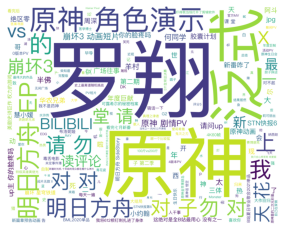

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
title = most_recent['title'].tolist()
title = ''.join(title)
wc = WordCloud(background_color='white', width=1000, height=800, font_path='PingFang.ttc')
wc.generate(title)
plt.imshow(wc)
plt.axis('off')
plt.show()
save_path = 'title_wordcloud.png'
wc.to_file(save_path)


In [4]:
cut_words('title')
cut_words('desc')
cut_words('dynamic')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/ts/yc6c7tl96hjdf33yyy_9y96m0000gn/T/jieba.cache
Loading model cost 1.813 seconds.
Prefix dict has been built successfully.


In [5]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))

In [6]:
perc_missing(most_recent)

Unnamed: 0 => 0.01%
desc => 10.09%
duration => 0.01%
stat => 0.01%
dynamic => 6.85%
bvid => 0.03%
owner => 0.03%
dimension => 0.03%


In [4]:
most_recent = pd.read_csv('most_recent.csv')

most_recent = most_recent.drop([11603,13849], axis=0)
#rearange the index
most_recent = most_recent.reset_index(drop=True)

#make each row of stat do dict
stat = most_recent['stat']
stat_dict = []
for i in stat:
    #if i is nan, make it to 0
    if type(i) == float:
        i = "{'aid': 0, 'view': 1, 'danmaku': 0, 'reply': 0, 'favorite': 0, 'coin': 0, 'share': 0, 'now_rank': 0, 'his_rank': 0, 'like': 0, 'dislike': 0, 'evaluation': 0, 'argue_msg': 0}"
    sd = eval(i)
    stat_dict.append(sd)
#make stat_dict to dataframe of dict
stat_dict = pd.DataFrame(stat_dict)

#drop columns that are not needed
stat_dict = stat_dict.drop(['aid','now_rank','his_rank','evaluation','argue_msg', 'dislike'],axis=1)
#replace stat with stat_dict
most_recent = most_recent.drop('stat',axis=1)
#concat most_recent and stat_dict and based on row number
most_recent = pd.concat([most_recent,stat_dict],axis=1)

In [5]:
owner = most_recent['owner']
owner_dict = []
for i in owner:
    #if i is nan, make it to 0
    if type(i) == float:
        i = "{'mid' : 0, 'name' : 0, 'face' : 0}"
    od = eval(i)
    owner_dict.append(od)
#make stat_dict to dataframe of dict
owner_dict = pd.DataFrame(owner_dict)

#drop columns that are not needed
owner_dict = owner_dict.drop('face',axis=1)
#replace stat with stat_dict
most_recent = most_recent.drop('owner',axis=1)
#concat most_recent and stat_dict and based on row number
most_recent = pd.concat([most_recent,owner_dict],axis=1)

In [6]:
#fill nan with 0
most_recent = most_recent.fillna(0)
coin = most_recent['coin']
favorite = most_recent['favorite']
danmaku = most_recent['danmaku']
reply = most_recent['reply']
view = most_recent['view']
like = most_recent['like']
share = most_recent['share']
for i in range(len(view)):
    if view[i] == 0:
        view[i] = 1
recommandation_rate = (coin * 1.2 + favorite * 0.9 + danmaku * 1.2 + 
                        reply * 1.2 + view * 0.75 + like * 1.2 + share * 1.8) / view
most_recent['recommandation_rate'] = recommandation_rate

/var/folders/ts/yc6c7tl96hjdf33yyy_9y96m0000gn/T/ipykernel_99194/3508209395.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view[i] = 1


In [7]:
#compute the recommandation rate mean and variance
#find outlyer in recommandation_rate
rr = most_recent['recommandation_rate']
rr_mean = rr.mean()
rr_std = rr.std()
print(rr_mean)
print(rr_std)

0.8782050469818125
0.1929761232682024


In [8]:
#add a column of recommandation_rate_level
rr_level = []
for i in rr:
    if i > rr_mean + 2 * rr_std:
        rr_level.append('highly recommend')
    elif i > 1:
        rr_level.append('recommend')
    elif i > rr_mean:
        rr_level.append('neutral')
    else:
        rr_level.append('not recommend')
most_recent['recommandation_rate_level'] = rr_level

In [9]:
most_recent.tail()

,Unnamed: 0,tid,tname,title,pubdate,ctime,desc,duration,dynamic,bvid,...,coin,share,like,mid,name,face,mid,name,recommandation_rate,recommandation_rate_level
14995,0.0,174,其他,三月，春花烂漫,1.584773e+09,1584773471,三月的都江,46,#摄影#,BV1jE411A7xD,...,0.0,0.0,1.0,0.0,0,0,289909700,竹影横窗lp,0.842308,not recommend
14996,0.0,137,明星综合,【德云社】积极营业小先生,1.584775e+09,1584775120,可可爱爱周九良,11,#周九良##栾云平#嘿嘿可可爱爱啾啾良,BV1jE411A74F,...,0.0,0.0,24.0,0.0,0,0,64729628,小迪迪迪呀呀,0.817467,not recommend
14997,0.0,172,手机游戏,48万出啥呢 一本满足 索然无味~,1.584772e+09,1584771843,。\n。。\n。。。\n。。。。\n。。。。。\n。。。。。。\n\n。\n\n。\n\n。...,36,#手机游戏##阴阳师##抽卡#,BV1jE411A74A,...,0.0,0.0,2.0,0.0,0,0,38422531,谁用时间慌乱了流年,0.987931,neutral
14998,0.0,137,明星综合,【少帮主】少酱在少酱的直播间放少酱的歌～极度宠粉的一天～音乐团get √ 百万修音师的封神之作 √,1.584774e+09,1584773543,【关于视频】少酱圈粉歌～一定要关注视频里面的聊天室！！！阿少把说唱的难听的队友举报了蛤蛤蛤蛤...,260,喜欢阿少！！！！\n我潇唱歌真好听！！！（。\n（我潇怼修音师那几句是真的傲娇了～）,BV1jE411A7xd,...,6.0,2.0,36.0,0.0,0,0,49878633,改名字隐藏一下自己,0.805755,not recommend
14999,0.0,138,搞笑,风 火 轮,1.584774e+09,1584773815,转自抖音号2098920150,17,#逗比##搞笑##风火轮#,BV1jE411A7xZ,...,0.0,0.0,0.0,0.0,0,0,28873018,px小飞侠,0.750000,not recommend


In [58]:
#save to csv
most_recent.to_csv('most_recent_updated.csv',index=False)

In [59]:
import numpy as np
import pandas as pd
#open csv
most_recent_updated = pd.read_csv('most_recent_updated.csv')

In [60]:
#将时间戳改为时间
most_recent_updated['pubdate'] = pd.to_datetime(most_recent_updated['pubdate'],unit='s')
print(most_recent_updated['pubdate'])

0       2020-03-20 21:28:25
1       2020-03-21 09:48:26
2       2020-03-21 08:45:10
3       2020-03-21 08:14:53
4       2020-03-21 09:27:47
                ...        
12486   2020-03-21 06:51:11
12487   2020-03-21 07:18:40
12488   2020-03-21 06:24:03
12489   2020-03-21 06:52:23
12490   2020-03-21 06:56:55
Name: pubdate, Length: 12491, dtype: datetime64[ns]


In [61]:
ctime = most_recent_updated['ctime']
c = []
for i in ctime:
    c.append(pd.to_datetime(i,unit='s'))
most_recent_updated['ctime'] = c

In [62]:
most_recent_updated.head()

,Unnamed: 0,tid,tname,title,pubdate,ctime,desc,duration,stat,dynamic,bvid,owner
0,0.0,17,单机游戏,青云：《生化危机3重置版》demo试玩解析,2020-03-20 21:28:25,2020-03-20 21:28:25,几个版本中体验最好的应该就是pc了。,998,"{'aid': 97890999, 'view': 9451, 'danmaku': 169...",正式版试玩来啦，特地等了一段时间，pc的游戏体验真是好了太多了#凤起青云解说##生化危机3重...,BV1vE411A7fv,"{'mid': 2117827, 'name': '凤起青云解说', 'face': 'ht..."
1,0.0,183,影视剪辑,罗云熙 | 润玉 水仙衍生剧【水云间Ⅱ】第五十一集 | 阎浮堤劫水 | 一念花开 万里星空寻一人,2020-03-21 09:48:26,2020-03-21 09:48:26,沝（zi）茀(fu),593,"{'aid': 97890996, 'view': 7362, 'danmaku': 234...",#全能打卡挑战##润玉##罗云熙##润玉水仙#,BV1vE411A7fB,"{'mid': 157294358, 'name': '重小夕_', 'face': 'ht..."
2,0.0,21,日常,咩咩所在地下雪啦-2020/03/14,2020-03-21 08:45:10,2020-03-21 08:45:10,2020年的第一场雪，比以往来的更晚一些～,76,"{'aid': 97890993, 'view': 46, 'danmaku': 0, 'r...",#有咩酱# #直播录屏#,BV1vE411A7fY,"{'mid': 306190030, 'name': '有咩酱后援会', 'face': '..."
3,0.0,65,网络游戏,这只鸭子真是给力，关键时刻就我一命。,2020-03-21 08:14:53,2020-03-21 08:14:53,-,554,"{'aid': 97890991, 'view': 4, 'danmaku': 0, 're...",#网络游戏##猫和老鼠手游##游戏视频#,BV1vE411A7fC,"{'mid': 244280775, 'name': '羲和与琼勾', 'face': 'h..."
4,0.0,17,单机游戏,欧卡2 日常,2020-03-21 09:27:47,2020-03-21 09:27:47,《尾随》,3833,"{'aid': 97890985, 'view': 48, 'danmaku': 0, 'r...",#欧洲卡车模拟2##欧卡2##单机联机#,BV1vE411A7fr,"{'mid': 43403384, 'name': '七斤大鹅', 'face': 'htt..."


In [63]:
most_recent_updated.to_csv('most_recent_updated.csv',index=False)